<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/2_distil_bert_advenced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (심화과제) Multi-genre natural language inference(MNLI)


In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

In [ ]:
import torch
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from torch.optim import AdamW
from tqdm import tqdm


In [146]:
import logging as log

for handler in log.root.handlers[:]:
    log.root.removeHandler(handler)

log.basicConfig(
    level= log.INFO,
)

device = 'cuda'
log.debug(device)

[MYCODE] nyu-mll/multi_nli 데이터셋 불러오기

- 데이터셋의 구조 파악하기

In [ ]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')
ds = load_dataset("nyu-mll/multi_nli")

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/tokenizer_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/nyu-mll/multi_nli/resolve/main/README.md HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:

[MYCODE] 토큰 시각화 하기

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

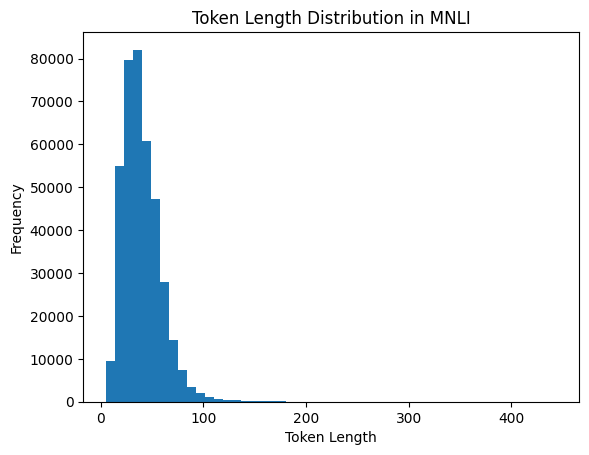

In [ ]:

# 토큰 길이 계산
def compute_length(example):
    tokens = tokenizer(example['premise'], example['hypothesis'], truncation=False)
    return len(tokens['input_ids'])

mnli_dataset = ds.map(lambda x: {"length": compute_length(x)})

# 길이 분포 확인
lengths = mnli_dataset['train']['length']

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution in MNLI")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

[MYCODE] 데이터셋 구조 확인
- ds 는 train, validation_matched, validation_mismatched 의 데이터를 가지고 있습니다.
- 레이블 분표율을 확인해본 결과 균등하게 있음을 확인

[FEEDBACK]
- 만약 레이블의 데이터가 균등하지 않다면 어떻게 해야할까요?
- 균등하지 않는 데이터를 하기 위해서 어떤 작업을 하면 좋나요 ?

In [ ]:
log.debug(ds)

# MemoryMappedTable
log.debug(f"type = {type(ds.data['train'])}")

# 학습 데이터의 레이블 분포 확인
labels = [example['label'] for example in ds['train']]
log.debug("Label Distribution:", Counter(labels))

# 데이터셋 구조를 확인합니다.
log.debug(f"{help(ds['train'])}")

DEBUG:root:DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})
DEBUG:root:type = <class 'datasets.table.MemoryMappedTable'>
DEBUG:root:Label Distribution:
DEBUG:root:None


Help on Dataset in module datasets.arrow_dataset object:

class Dataset(DatasetInfoMixin, datasets.search.IndexableMixin, TensorflowDatasetMixin)
 |  Dataset(arrow_table: datasets.table.Table, info: Optional[datasets.info.DatasetInfo] = None, split: Optional[datasets.splits.NamedSplit] = None, indices_table: Optional[datasets.table.Table] = None, fingerprint: Optional[str] = None)
 |  
 |  A Dataset backed by an Arrow table.
 |  
 |  Method resolution order:
 |      Dataset
 |      DatasetInfoMixin
 |      datasets.search.IndexableMixin
 |      TensorflowDatasetMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, exc_type, exc_val, exc_tb)
 |  
 |  __getitem__(self, key)
 |      Can be used to index columns (by string names) or rows (by integer index or iterable of indices or bools).
 |  
 |  __getitems__(self, keys: List) -> List
 |      Can be used to get a batch using a list of integers indices.
 |  
 | 

In [ ]:
ds['train'].features

{'promptID': Value(dtype='int32', id=None),
 'pairID': Value(dtype='string', id=None),
 'premise': Value(dtype='string', id=None),
 'premise_binary_parse': Value(dtype='string', id=None),
 'premise_parse': Value(dtype='string', id=None),
 'hypothesis': Value(dtype='string', id=None),
 'hypothesis_binary_parse': Value(dtype='string', id=None),
 'hypothesis_parse': Value(dtype='string', id=None),
 'genre': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)}

In [ ]:
def to_tokenizer_fn(text, max_length=128):
    return tokenizer(text, padding=True, truncation=True, max_length=max_length)

def to_long_tensor_fn(input_tokenizer):
    return torch.LongTensor(input_tokenizer)

In [ ]:
def collate_fn(batch):

  texts, labels = [], []
  for row in batch:
    texts.append(f"{row['premise']} [SEP] {row['hypothesis']}")
    labels.append(row['label'])

  token = to_long_tensor_fn(to_tokenizer_fn(texts, 128).input_ids)
  attention_mask = to_long_tensor_fn(to_tokenizer_fn(texts).attention_mask)
  label = to_long_tensor_fn(labels)
  log.debug(token)
  log.debug(attention_mask)
  log.debug(label)
  return token, attention_mask, label


[MYCODE] 레이블별 균등하게 데이터를 생성한다.

[MYCDOE] 데이터로더를 생성

- 학습데이터
- 검증 데이터
- 빠른 모델 검증을 위한 작은 수의 데이터만을 학습

GPU 사용시 pim_memory를 켜줘야 성능이 올라간다는 내용을 보게 되어 옵션을 설정했습니다.

In [ ]:
# 데이터 학습 데이터셋
train_loader = DataLoader(
    ds['train'], batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2
)

# 데이터 검증 데이터셋
test_loader = DataLoader(
    ds['validation_matched'], batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=2
)

log.debug(train_loader.dataset)
log.debug(test_loader.dataset)


DEBUG:root:Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 392702
})
DEBUG:root:Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 9815
})


[MYCODE] 학습할 데이터의 정보를 확인합니다.

- 두개의 문장을 하나로 합치는 작업을 선행 확인해보기
    - 두 문장을 구분하는 값이 SEP 102으로 분리 되었는지 확인해보았습니다.


[MYCODE] train_dataloaders 에 따라 loader 변경 기능 추가
- train_dataLoaders 할당하는 loader로 학습 변경하기 위해 선언

In [57]:
train_dataloaders = train_loader
test_dataloaders = test_loader
log.debug(f"train_dataloaders = {train_dataloaders.dataset}")
log.debug(f"test_dataloaders = {test_dataloaders.dataset}")

DEBUG:root:train_dataloaders = Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 392702
})
DEBUG:root:test_dataloaders = Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 9815
})


[MYCODE] callate_fn 변경으로 인한 데이터 검증 확인을 위해 데이터 확인

[FEEDBACK]
- 데이터를 검증하는 작업을 눈으로 확인하게 되었는데 python 또는 AI 모델에서 데이터를 검증하기 위한 수단이 무엇이 있을까요
    - TDD 같은 개념의 방법이 있나요?
    - assert 검증을 하는 방식인지 궁금합니다.

In [141]:
dataset_premise = train_dataloaders.dataset['premise']
dataset_hypothesis = train_dataloaders.dataset["hypothesis"]
dataset_labels = train_dataloaders.dataset["label"]

# 데이터 구조확인

log.debug(f"dataset_premise =  {dataset_premise[0:10]}")
log.debug(f"dataset_hypothesis = {dataset_hypothesis[0:10]}")
log.debug(f"dataset_labels = {dataset_labels[0:10]}")

#테스트 데이터 확인
dataset_premise = test_dataloaders.dataset['premise']
dataset_hypothesis = test_dataloaders.dataset["hypothesis"]
dataset_labels = test_dataloaders.dataset["label"]

log.debug(f"dataset_premise =  {dataset_premise[0:10]}")
log.debug(f"dataset_hypothesis = {dataset_hypothesis[0:10]}")
log.debug(f"dataset_labels = {dataset_labels[0:10]}")

# 토크나이저 102 값이 중간에 넣어졌는지 확인하기
log.debug(f"{to_tokenizer_fn(dataset_premise[0:10])}")
log.debug(f"{to_tokenizer_fn(dataset_hypothesis[0:10])}")



DEBUG:root:dataset_premise =  ['Conceptually cream skimming has two basic dimensions - product and geography.', 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'One of our number will carry out your instructions minutely.', 'How do you know? All this is their information again.', "yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range", "my walkman broke so i'm upset now i just have to turn the stereo up real loud", 'But a few Christian mosaics survive above the apse is the Virgin with the infant Jesus, with the Archangel Gabriel to the right (his companion Michael, to the left, has vanished save for a few feathers from his wings).', "(Read  for Slate 's take on Jack

In [66]:
from torch import nn

class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 3)

  def forward(self, x, attention_mask):
    x = self.encoder(input_ids=x, attention_mask=attention_mask)
    return self.classifier(x.last_hidden_state[:, 0])

In [61]:
import numpy as np
import matplotlib.pyplot as plt
def live_plot(train_accs, test_accs, title="Real-time Accuracy", label1='train', label2='test'):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 8))

    # 1번째 서브플롯: Train_loss vs test
    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label='train', color='blue')  # 훈련 손실
    plt.plot(x, test_accs, label='test', color='red', marker='o')  # 검증 손실
    plt.title("Train_acc vs test_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()


    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()

In [62]:
from torch.amp import GradScaler, autocast
def accuracy(model, dataloader):
  cnt = 0
  acc = 0


  with torch.no_grad():
    for i, data in enumerate(dataloader):
      log.debug(f"{i+1}/{len(dataloader)} 번째 배치를 처리 중입니다.")

      inputs, attention_mask, labels = data
      log.debug(f"입력 데이터 크기: {inputs.shape}, 레이블 크기: {labels.shape}.")

      inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
      log.debug("입력 데이터, attention_mask, 레이블을 디바이스로 이동했습니다.")


      # Mixed Precision 적용
      with autocast(device):  # 최신 방식으로 autocast 사용
        preds = model(inputs, attention_mask)
        preds = torch.argmax(preds, dim=-1)
        log.debug(f"모델 출력 크기: {preds.shape}.")
        log.debug(f"처리된 예측값(상위 5개): {preds[:5]}.")# 모델 예측

      # 정확도 계산 (GPU에서 처리)
      correct = (labels == preds).sum()  # GPU에서 처리
      cnt += labels.size(0)
      acc += correct.item()
  return acc / cnt

[MYCODE] 구글드라이브에 모델 저장
- 학습모델 시간이 오래걸리는 문제를 해결하기 위해서 모델을 에포크마다 저장한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [63]:
def save_checkpoint(epoch, model, optimizer, best_loss, counter, train_losses, train_accs, test_accs, filepath):
    """
    학습 상태를 저장하는 함수
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'counter': counter,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }
    torch.save(checkpoint, filepath)
    log.info(f"Checkpoint saved at {filepath}")

In [64]:
def load_checkpoint(filepath, model, optimizer):
    """
    저장된 학습 상태를 복구하는 함수
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    counter = checkpoint['counter']
    train_losses = checkpoint['train_losses']
    train_accs = checkpoint['train_accs']
    test_accs = checkpoint['test_accs']
    log.info(f"Checkpoint loaded from {filepath}")
    return epoch, best_loss, counter, train_losses, train_accs, test_accs

In [67]:
model = TextClassifier()
log.debug(model)
for param in model.encoder.parameters():
  param.requires_grad = False


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
DEBUG:urllib3.connectionpool:Resetting dropped connection: huggingface.co
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/config.json HTTP/11" 200 0
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:jax._src.path:etils.epath found. Using etils.epath for file I/O.
DEBUG:root:TextClassifier(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace

[MYCODE] 모델학습하기
아래 총 세 가지의 학습 시도가 있습니다

1. 전체데이터를 학습하는 모델 required = False
2. 마지막 레이어 2개만 required = True
3. 데이터 로더를 줄여서 최종적으로 학습해보기


- 전체데이터
  - 성능 향상을 위해서
  AdamW,  Mixed Precision 적용, 학습상태를 저장하여 세션이 끊기거나 학습 loss가 줄어지지 않는 문제를 해결하기 위해서 earlyStop을 적용하였습니다.

100%|██████████| 12272/12272 [05:06<00:00, 40.07it/s]
INFO:root:Epoch 1: avg improved to 1.022.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_1.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_1.pth


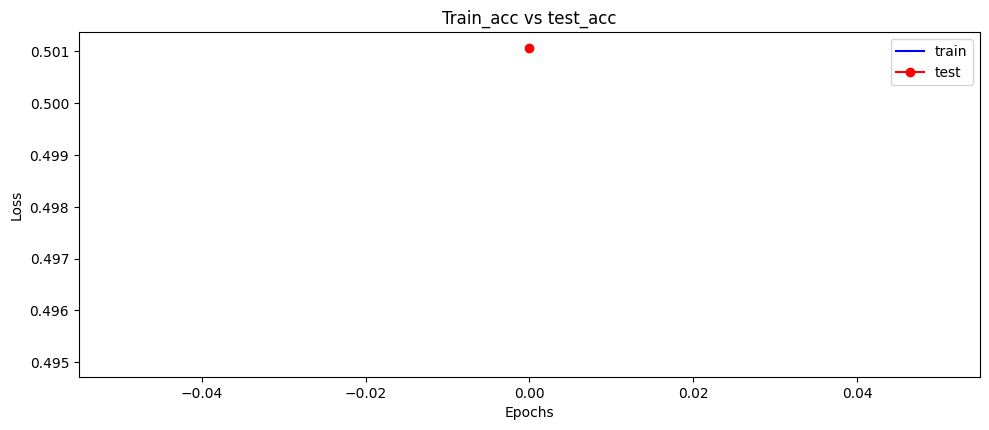

INFO:root:Epoch 1 | Train Loss: 1.022 | Train Acc: 0.495 | Test Acc: 0.501
100%|██████████| 12272/12272 [05:04<00:00, 40.28it/s]
INFO:root:Epoch 2: avg improved to 1.010.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_2.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_2.pth


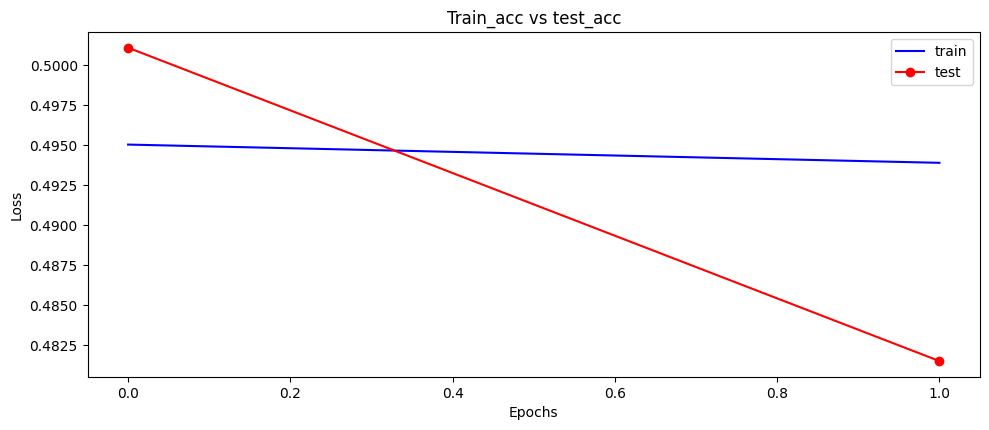

INFO:root:Epoch 2 | Train Loss: 1.010 | Train Acc: 0.494 | Test Acc: 0.482
100%|██████████| 12272/12272 [05:00<00:00, 40.81it/s]
INFO:root:Epoch 3: avg improved to 1.009.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_3.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_3.pth


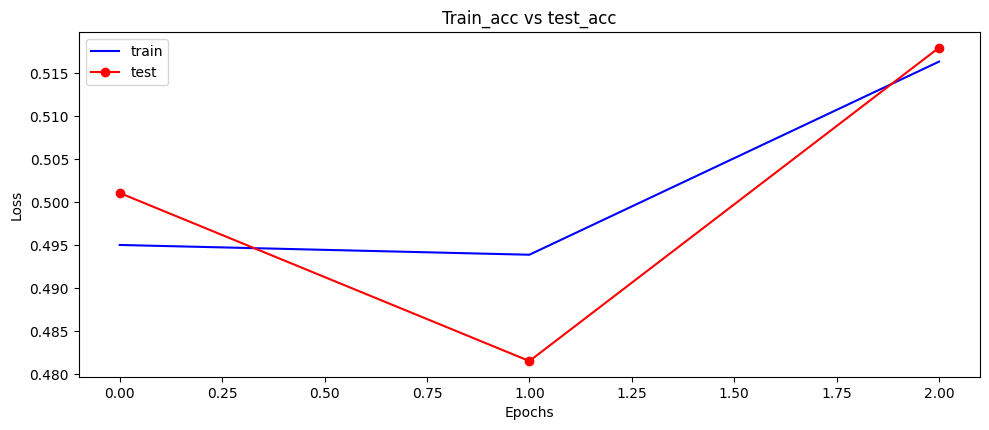

INFO:root:Epoch 3 | Train Loss: 1.009 | Train Acc: 0.516 | Test Acc: 0.518
100%|██████████| 12272/12272 [04:58<00:00, 41.06it/s]
INFO:root:Epoch 4: avg improved to 1.008.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_4.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_4.pth


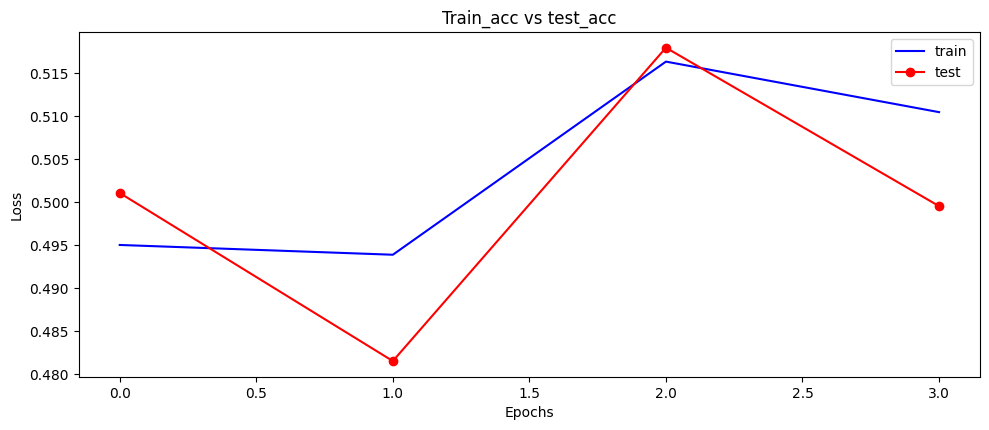

INFO:root:Epoch 4 | Train Loss: 1.008 | Train Acc: 0.510 | Test Acc: 0.500
100%|██████████| 12272/12272 [05:02<00:00, 40.58it/s]
INFO:root:Epoch 5: Loss did not improve for 1 consecutive epochs.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_5.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_5.pth


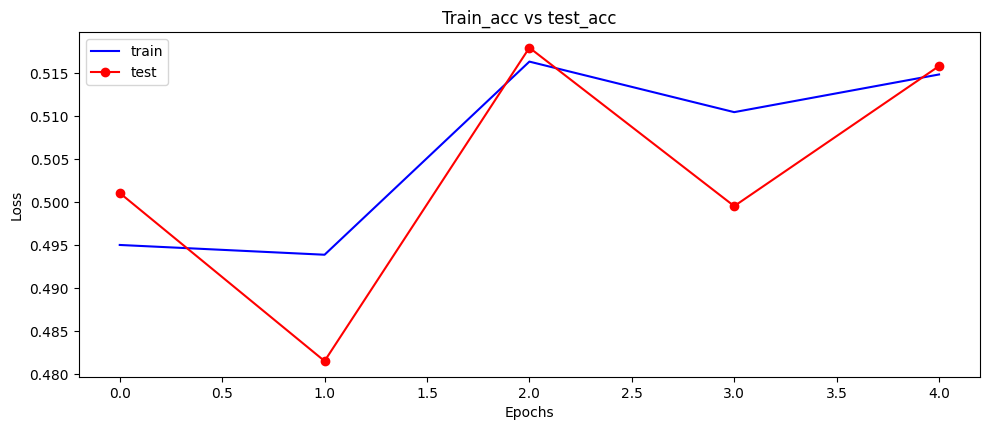

INFO:root:Epoch 5 | Train Loss: 1.009 | Train Acc: 0.515 | Test Acc: 0.516
100%|██████████| 12272/12272 [05:03<00:00, 40.42it/s]
INFO:root:Epoch 6: avg improved to 1.008.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_6.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_6.pth


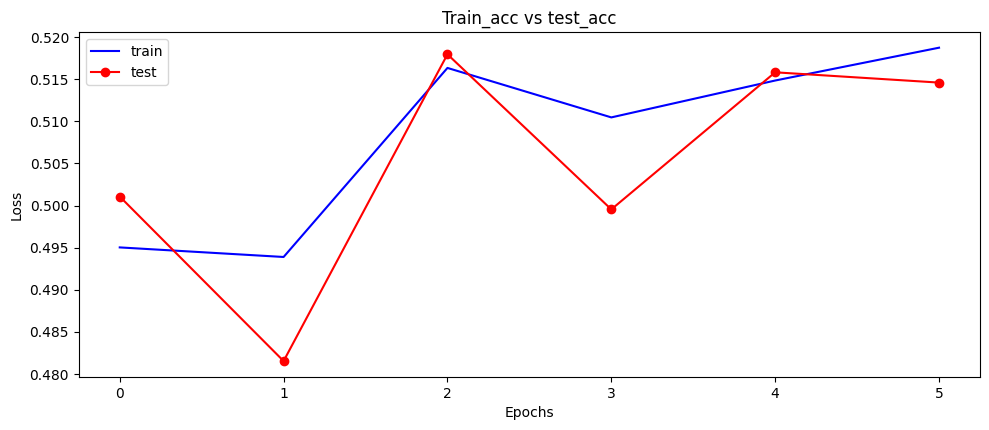

INFO:root:Epoch 6 | Train Loss: 1.008 | Train Acc: 0.519 | Test Acc: 0.515
100%|██████████| 12272/12272 [05:05<00:00, 40.21it/s]
INFO:root:Epoch 7: Loss did not improve for 1 consecutive epochs.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_7.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_7.pth


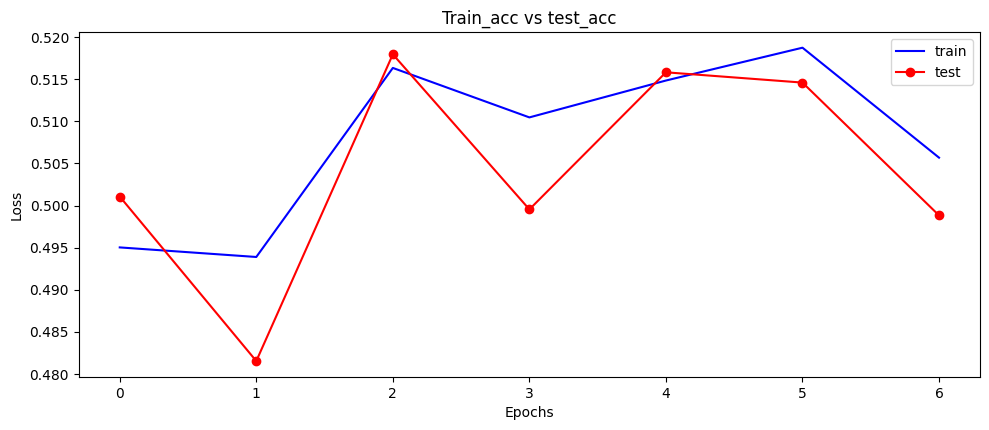

INFO:root:Epoch 7 | Train Loss: 1.008 | Train Acc: 0.506 | Test Acc: 0.499
100%|██████████| 12272/12272 [05:01<00:00, 40.70it/s]
INFO:root:Epoch 8: Loss did not improve for 2 consecutive epochs.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_8.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_8.pth


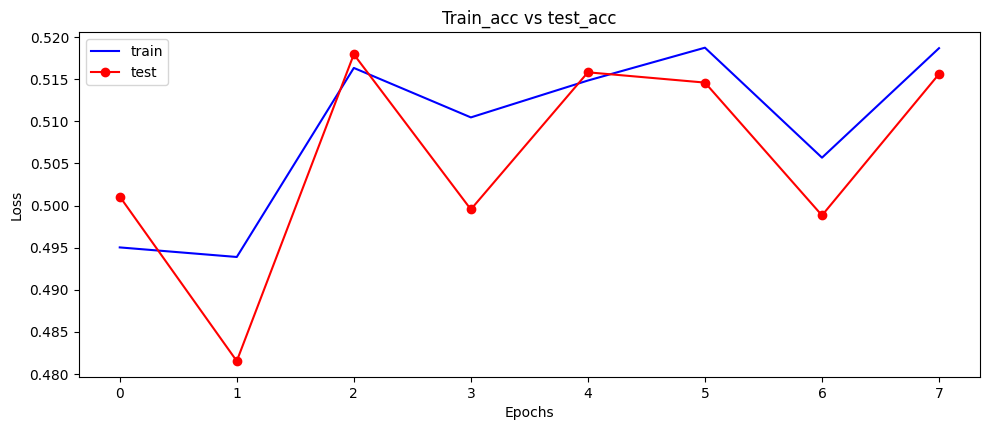

INFO:root:Epoch 8 | Train Loss: 1.008 | Train Acc: 0.519 | Test Acc: 0.516
100%|██████████| 12272/12272 [05:05<00:00, 40.12it/s]
INFO:root:Epoch 9: Loss did not improve for 3 consecutive epochs.
INFO:root:Checkpoint saved at /content/drive/My Drive/before_distil_bert_advenced_epoch_9.pth
INFO:root:Checkpoint saved at /content/drive/My Drive/after_distil_bert_advenced_epoch_9.pth


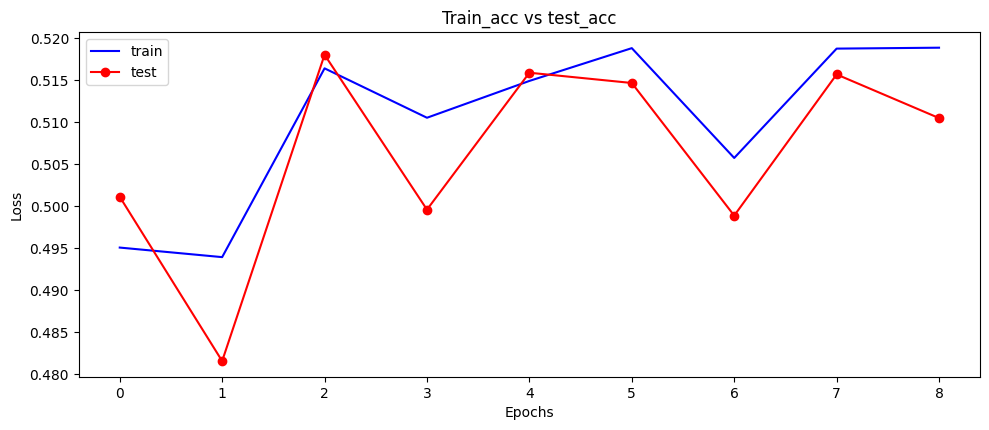

INFO:root:Epoch 9 | Train Loss: 1.008 | Train Acc: 0.519 | Test Acc: 0.510
 16%|█▌        | 1952/12272 [00:48<03:48, 45.08it/s]

In [ ]:
lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=lr, weight_decay= 1e-2)
n_epochs = 10
scaler = GradScaler()  # Mixed Precision Training

best_loss = float('inf')
patience = 5
train_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    total_loss = 0.0
    total_samples = 0
    model.train()
    for data in tqdm(train_dataloaders):
        model.zero_grad()
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

        # Mixed Precision 적용
        with autocast(device):  # 최신 방식으로 autocast 사용
            preds = model(inputs, attention_mask)
            loss = loss_fn(preds, labels)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    train_losses.append(avg_loss)

    # 손실 감소 확인
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        log.info(f"Epoch {epoch + 1}: avg improved to {avg_loss:.3f}.")
    else:
        counter += 1
        log.info(f"Epoch {epoch + 1}: Loss did not improve for {counter} consecutive epochs.")

    # 학습 중단 조건
    if counter >= patience:
        log.info(f"Stopping early at epoch {epoch + 1}. Best Loss: {best_loss:.3f}")
        break

    # 모델 평가전 저장
    save_path = f"/content/drive/My Drive/before_distil_bert_advenced_epoch_{epoch + 1}.pth"
    save_checkpoint(epoch + 1, model, optimizer, best_loss, counter, train_losses, train_accs, test_accs, save_path)

    # 모델 평가
    model.eval()
    train_acc = accuracy(model, train_dataloaders)
    test_acc = accuracy(model, test_dataloaders)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # 학습 상태 저장
    save_path = f"/content/drive/My Drive/after_distil_bert_advenced_epoch_{epoch + 1}.pth"
    save_checkpoint(epoch + 1, model, optimizer, best_loss, counter, train_losses, train_accs, test_accs, save_path)

    # 시각화와 로그
    live_plot(train_accs, test_accs)
    log.info(f"Epoch {epoch + 1} | Train Loss: {avg_loss:.3f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

[MYCODE] 로스가 줄어들지 않는 문제를 해결하기 위해 마지막 레이어만 학습을 활성화하기

- 마지막 레이어만 2개만 활성화하여 로스를 줄어들게 하였습니다.
- 실제 학습시간은 늘어나게 되었지만 파라미터를 활성화 함으로써 로스가 줄어드는 걸 확인하였습니다.
- 실제 로스가 줄어드는지 확인하고 하였기에 학습을 3에폭에서 강제 종료했습니다.



[FEEDBACK] 부분 레이어 학습에 대한 문제점에 대해 궁금합니다.
2개의 레이어만 업데이트를 하게 된다면 어떻게 가중치가 학습될지 예측이 안 되는데요.    
MH
앞의 레이어층에서는 업데이트가 되지 않고 2개의 레이어서 전체적으로 가중치가 업데이트 되는걸까요?
부분적으로 처리하게 된다면 문제가 없을까하는 생각도 듭니다.




In [111]:

class Text2LayerClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 3)
    # 모든 레이어를 고정 (학습 비활성화)
    for param in self.encoder.parameters():
        param.requires_grad = False

    # 마지막 2개 레이어만 학습 활성화
    for layer in self.encoder.transformer.layer[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

  def forward(self, x, attention_mask):
    x = self.encoder(input_ids=x, attention_mask=attention_mask)
    return self.classifier(x.last_hidden_state[:, 0])

model = Text2LayerClassifier()
for name, param in model.encoder.named_parameters():
    print(name, param.requires_grad)

embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
transformer.layer.0.attention.q_lin.weight False
transformer.layer.0.attention.q_lin.bias False
transformer.layer.0.attention.k_lin.weight False
transformer.layer.0.attention.k_lin.bias False
transformer.layer.0.attention.v_lin.weight False
transformer.layer.0.attention.v_lin.bias False
transformer.layer.0.attention.out_lin.weight False
transformer.layer.0.attention.out_lin.bias False
transformer.layer.0.sa_layer_norm.weight False
transformer.layer.0.sa_layer_norm.bias False
transformer.layer.0.ffn.lin1.weight False
transformer.layer.0.ffn.lin1.bias False
transformer.layer.0.ffn.lin2.weight False
transformer.layer.0.ffn.lin2.bias False
transformer.layer.0.output_layer_norm.weight False
transformer.layer.0.output_layer_norm.bias False
transformer.layer.1.attention.q_lin.weight False
transformer.layer.1.attention.q_lin.bias False
transforme

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [112]:
lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=lr, weight_decay= 1e-2)
n_epochs = 3
scaler = GradScaler()  # Mixed Precision Training

for epoch in range(n_epochs):
    total_loss = 0.0
    total_samples = 0
    model.train()
    for data in tqdm(train_dataloaders):
        model.zero_grad()
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

        # Mixed Precision 적용
        with autocast(device):  # 최신 방식으로 autocast 사용
            preds = model(inputs, attention_mask)
            loss = loss_fn(preds, labels)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    log.info(f"Epoch {epoch + 1}: avg improved to {avg_loss:.3f}.")

100%|██████████| 12272/12272 [07:59<00:00, 25.59it/s]
INFO:root:Epoch 1: avg improved to 0.973.
100%|██████████| 12272/12272 [08:06<00:00, 25.22it/s]
INFO:root:Epoch 2: avg improved to 0.913.
100%|██████████| 12272/12272 [08:04<00:00, 25.35it/s]
INFO:root:Epoch 3: avg improved to 0.903.


[MYCODE] 최종적으로 모델 학습
- 전체 파라미터를 학습할 수 있도록 파라미터 관련된 코드를 삭제했습니다.
- 모델 학습은 이전과 동일합니다.
- 다양한 메트릭 사용해보기

In [152]:
from collections import defaultdict
import random

def create_balanced_subset(dataset, samples_per_label, is_suffle):
    """
    각 레이블별로 균등하게 샘플링된 서브셋을 생성.

    Args:
        dataset: 전체 데이터셋 (HuggingFace Dataset 형태)
        samples_per_label: 각 레이블별 샘플링할 개수

    Returns:
        PyTorch Dataset 객체
    """
    label_to_samples = defaultdict(list)

    # 데이터셋을 라벨별로 분류
    for example in dataset:
        label_to_samples[example["label"]].append(example)

    # 각 레이블별로 샘플링
    balanced_samples = []
    for label, samples in label_to_samples.items():
        if len(samples) < samples_per_label:
            raise ValueError(f"Not enough samples for label {label}.")

        # 레이블별 샘플링
        val = random.sample(samples, samples_per_label)
        balanced_samples.extend(val)

    # 전체 리스트를 랜덤하게 섞기
    if (is_suffle):
      random.shuffle(balanced_samples)

    # 데이터셋 객체로 변환
    data = Dataset.from_list(balanced_samples)
    return data

[MYCODE] 빠른 모델 검증을 위하여 작은 수의 데이터로 검증

- 각 레이블 별 4000 개씩 * 3 = 12,000 개 학습데이터 생성

- valid_loader 400 개씩 * 3 = 1200 개 약 10% 데이터로 검증한다.

In [169]:

# 빠른 모델 검증을 위한 작은 수의 데이터만을 학습
train_loader_small = create_balanced_subset(ds['train'], 10000, True)
train_loader_small = DataLoader(
    train_loader_small, batch_size=32, shuffle=True, collate_fn=collate_fn
)

valid_loader_small = create_balanced_subset(ds['validation_matched'], 400, True)
valid_loader_small = DataLoader(
    valid_loader_small, batch_size=32, shuffle=False, collate_fn=collate_fn
)


In [145]:
log.info(train_loader_small.dataset)
log.info(valid_loader_small.dataset)

dataset_premise = train_loader_small.dataset['premise']
dataset_hypothesis = train_loader_small.dataset["hypothesis"]
dataset_labels = train_loader_small.dataset["label"]

valid_dataset_premise = valid_loader_small.dataset['premise']
valid_dataset_hypothesis = valid_loader_small.dataset["hypothesis"]
valid_dataset_labels = valid_loader_small.dataset["label"]

log.info(dataset_premise[0:100])
log.info(dataset_hypothesis[0:100])
log.info(dataset_labels[0:100])

log.info(valid_dataset_premise[0:100])
log.info(valid_dataset_hypothesis[0:100])
log.info(valid_dataset_labels[400:500])

INFO:root:Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 12000
})
INFO:root:Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 1200
})
INFO:root:['Another slam of the warclub caved in the dog helm in an explosion of blood.', 'There are dozens of shops, a spa, and a branch of the Bishop Museum in the Kalia Tower.', 'That was the spasm of sex and the drunkenness of drink.', "Shiva's wife is Parvati, also called Annapurna in Nepal.", "okay nineteen eighty four there are like three big continents and uh there's just this area like around Egypt and stuff that everybody's fighting over now the problem is is that nobody's going to invade anybody else's boundaries", '(per piece, delivery and stop), and the numb

[MYCODE] 메트릭 생성

- 정확성 , 정확도 , 재현율,

In [183]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, dataloader):
    """모델 평가를 위한 함수."""
    model.eval()  # 평가 모드
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            log.debug(f"{i+1}/{len(dataloader)} 번째 배치를 처리 중입니다.")

            inputs, attention_mask, labels = data
            log.debug(f"입력 데이터 크기: {inputs.shape}, 레이블 크기: {labels.shape}.")

            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            log.debug("입력 데이터, attention_mask, 레이블을 디바이스로 이동했습니다.")

            # Mixed Precision 적용
            with autocast(device):  # Mixed Precision 적용
                preds = model(inputs, attention_mask)

            preds = torch.argmax(preds, dim=-1)  # 가장 높은 클래스 선택
            log.debug(f"모델 출력 크기: {preds.shape}.")
            log.debug(f"처리된 예측값(상위 5개): {preds[:5]}.")  # 모델 예측

            # 리스트에 예측값과 실제값 추가
            all_preds.extend(preds.cpu().numpy())  # 예측값을 리스트에 추가
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨을 리스트에 추가

    # 성능 평가
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return {"accuracy": accuracy, "recall": recall, "f1": f1}

# 메트릭 Append 함수
def log_metrics(metrics_dict, epoch_metrics):
    metrics_dict["accuracy"].append(epoch_metrics["accuracy"])
    metrics_dict["recall"].append(epoch_metrics["recall"])
    metrics_dict["f1"].append(epoch_metrics["f1"])

# 메트릭 정보를 plot 하기 위한 함수
def plot_metric(train_metric, test_metric, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_metric) + 1), train_metric, label=f"Train {metric_name}")
    plt.plot(range(1, len(test_metric) + 1), test_metric, label=f"Test {metric_name}")
    plt.title(f"{metric_name} per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

In [177]:

class TextLayerParamerAllTrueClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 3)
    # 분류기 초기화
    nn.init.xavier_uniform_(self.classifier.weight)  # Xavier 초기화
    nn.init.zeros_(self.classifier.bias)             # Bias 초기화
        # 모든 레이어를 고정 (학습 비활성화)
    for param in self.encoder.parameters():
        param.requires_grad = False

    # 마지막 2개 레이어만 학습 활성화
    for layer in self.encoder.transformer.layer[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

  def forward(self, x, attention_mask):
    x = self.encoder(input_ids=x, attention_mask=attention_mask)
    return self.classifier(x.last_hidden_state[:, 0])

model = TextLayerParamerAllTrueClassifier()
for name, param in model.encoder.named_parameters():
    print(name, param.requires_grad)

embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
transformer.layer.0.attention.q_lin.weight False
transformer.layer.0.attention.q_lin.bias False
transformer.layer.0.attention.k_lin.weight False
transformer.layer.0.attention.k_lin.bias False
transformer.layer.0.attention.v_lin.weight False
transformer.layer.0.attention.v_lin.bias False
transformer.layer.0.attention.out_lin.weight False
transformer.layer.0.attention.out_lin.bias False
transformer.layer.0.sa_layer_norm.weight False
transformer.layer.0.sa_layer_norm.bias False
transformer.layer.0.ffn.lin1.weight False
transformer.layer.0.ffn.lin1.bias False
transformer.layer.0.ffn.lin2.weight False
transformer.layer.0.ffn.lin2.bias False
transformer.layer.0.output_layer_norm.weight False
transformer.layer.0.output_layer_norm.bias False
transformer.layer.1.attention.q_lin.weight False
transformer.layer.1.attention.q_lin.bias False
transforme

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [175]:
next(iter(train_loader_small))

(tensor([[  101,  1998,  2057,  ...,     0,     0,     0],
         [  101,  2092,  2216,  ...,     0,     0,     0],
         [  101,  4067,  2017,  ...,     0,     0,     0],
         ...,
         [  101,  2320, 10470,  ...,     0,     0,     0],
         [  101,  2045,  2024,  ...,     0,     0,     0],
         [  101,  2066,  2035,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1, 2, 0, 2, 1, 0, 1, 2, 1, 2,
         1, 0, 2, 2, 0, 0, 1, 1]))

[MYCODE] 과소적합 문제를 해결 하기 위해 전체 모델이 아닌 2개만 파라미터를 풀어서 처리

- 전체 모델을 파라미터를 학습하는 경우 30% 수렴

- 마지막 레이어 2개만 파라미터 가중치 학습
- 학습 데이터 12,000
- 검증 데이터 1,200
- accuracy , recall, f1 을 이용하여 다양한 매트릭으로 데이터 확인


100%|██████████| 938/938 [00:42<00:00, 22.12it/s]
INFO:root:Epoch 1: avg improved to 0.870.
INFO:root:Epoch 1 | Train Metrics: {'accuracy': 0.6188, 'recall': 0.6188, 'f1': 0.619558908396334} | Test Metrics: {'accuracy': 0.5825, 'recall': 0.5825, 'f1': 0.5830245838301806}
100%|██████████| 938/938 [00:42<00:00, 22.30it/s]
INFO:root:Epoch 2: avg improved to 0.879.
INFO:root:Epoch 2 | Train Metrics: {'accuracy': 0.609, 'recall': 0.609, 'f1': 0.6019286278498444} | Test Metrics: {'accuracy': 0.5516666666666666, 'recall': 0.5516666666666666, 'f1': 0.5448390203975705}
100%|██████████| 938/938 [00:41<00:00, 22.49it/s]
INFO:root:Epoch 3: avg improved to 0.858.
INFO:root:Epoch 3 | Train Metrics: {'accuracy': 0.6411, 'recall': 0.6411, 'f1': 0.6410252175487345} | Test Metrics: {'accuracy': 0.6008333333333333, 'recall': 0.6008333333333333, 'f1': 0.6012217448467155}
100%|██████████| 938/938 [00:41<00:00, 22.52it/s]
INFO:root:Epoch 4: avg improved to 0.846.
INFO:root:Epoch 4 | Train Metrics: {'accurac

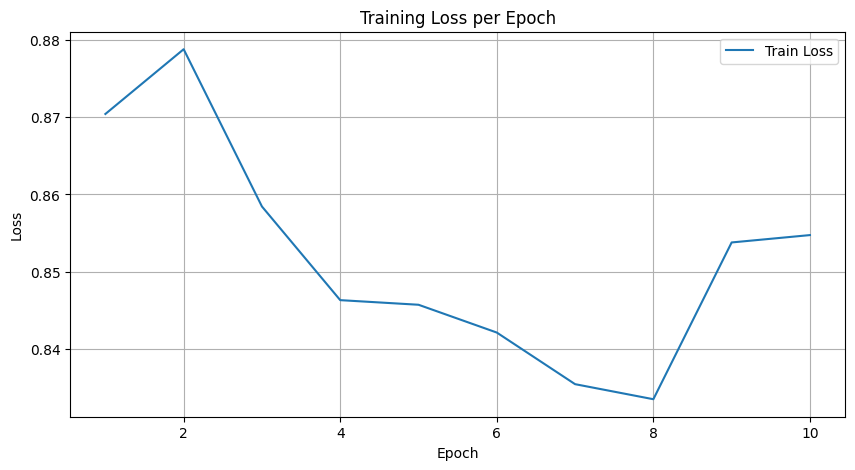

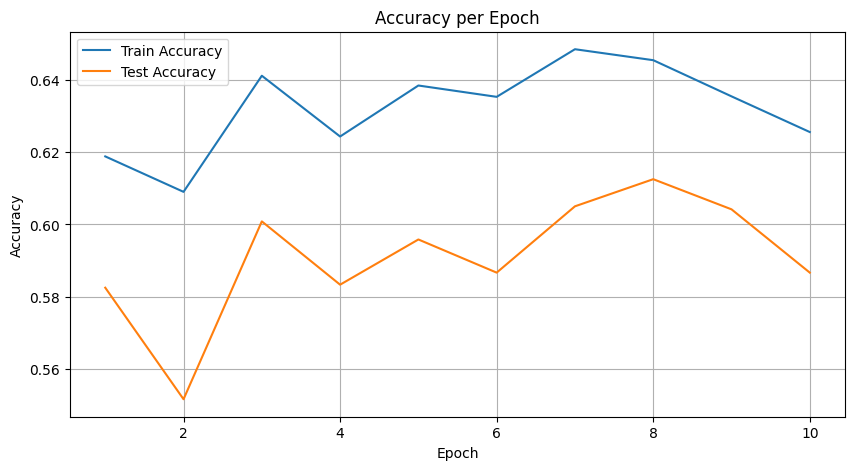

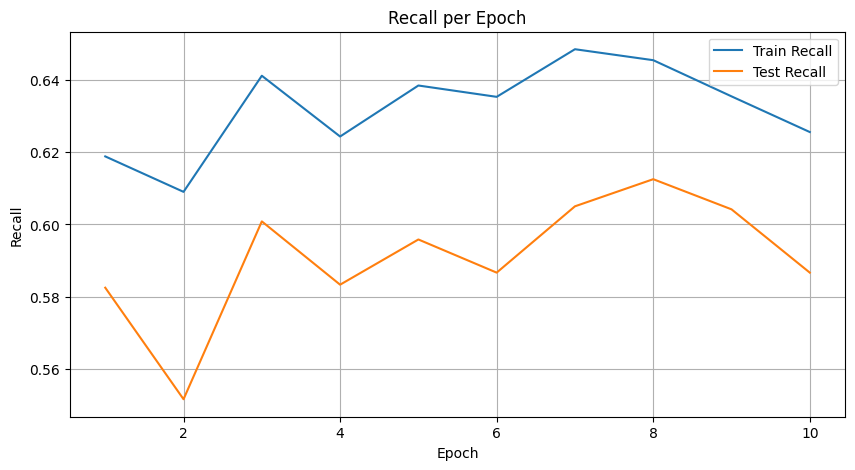

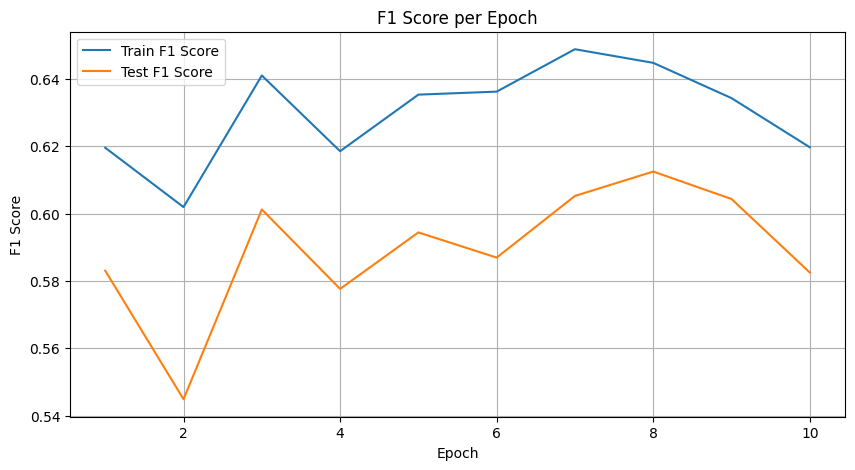

In [186]:
train_metrics = {"accuracy": [], "recall": [], "f1": []}
test_metrics = {"accuracy": [],  "recall": [], "f1": []}
train_losses = []

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=lr, weight_decay= 1e-2)
n_epochs = 10
scaler = GradScaler()  # Mixed Precision Training

for epoch in range(n_epochs):
    total_loss = 0.0
    total_samples = 0
    model.train()
    for data in tqdm(train_loader_small):
        model.zero_grad()
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

        # Mixed Precision 적용
        with autocast(device):  # 최신 방식으로 autocast 사용
            preds = model(inputs, attention_mask)
            loss = loss_fn(preds, labels)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    train_losses.append(avg_loss)
    log.info(f"Epoch {epoch + 1}: avg improved to {avg_loss:.3f}.")
    train_metric = evaluate_model(model, train_loader_small)
    test_metric = evaluate_model(model, valid_loader_small)
    log_metrics(train_metrics, train_metric)
    log_metrics(test_metrics, test_metric)

    log.info(f"Epoch {epoch + 1} | Train Metrics: {train_metric} | Test Metrics: {test_metric}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plot_metric(train_metrics["accuracy"], test_metrics["accuracy"], "Accuracy")
plot_metric(train_metrics["recall"], test_metrics["recall"], "Recall")
plot_metric(train_metrics["f1"], test_metrics["f1"], "F1 Score")
